# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

import pickle


In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 500)

In [3]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('DisasterResponse_table', engine)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that could pass over Haiti,Un front froid se retrouve sur Cuba ce matin. Il pourrait traverser Haiti demain. Des averses de pluie isolee sont encore prevues sur notre region ce soi,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ak timoun yo. Mesi se john jean depi Monben kwochi.",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country today and tonight",facade ouest d Haiti et le reste du pays aujourd hui et ce soir,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
df.shape

(26216, 40)

In [5]:
df.describe()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26216.00000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.0,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,15224.82133,0.773650,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,0.0,0.063778,0.111497,0.088267,0.015449,0.023039,0.011367,0.033377,0.045545,0.131446,0.065037,0.045812,0.050847,0.020293,0.006065,0.010795,0.004577,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584
std,8826.88914,0.435276,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,0.0,0.244361,0.314752,0.283688,0.123331,0.150031,0.106011,0.179621,0.208500,0.337894,0.246595,0.209081,0.219689,0.141003,0.077643,0.103338,0.067502,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114
min,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7446.75000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15662.50000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22924.25000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30265.00000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26216 entries, 0 to 26215
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      26216 non-null  int64 
 1   message                 26216 non-null  object
 2   original                10170 non-null  object
 3   genre                   26216 non-null  object
 4   related                 26216 non-null  int64 
 5   request                 26216 non-null  int64 
 6   offer                   26216 non-null  int64 
 7   aid_related             26216 non-null  int64 
 8   medical_help            26216 non-null  int64 
 9   medical_products        26216 non-null  int64 
 10  search_and_rescue       26216 non-null  int64 
 11  security                26216 non-null  int64 
 12  military                26216 non-null  int64 
 13  child_alone             26216 non-null  int64 
 14  water                   26216 non-null  int64 
 15  fo

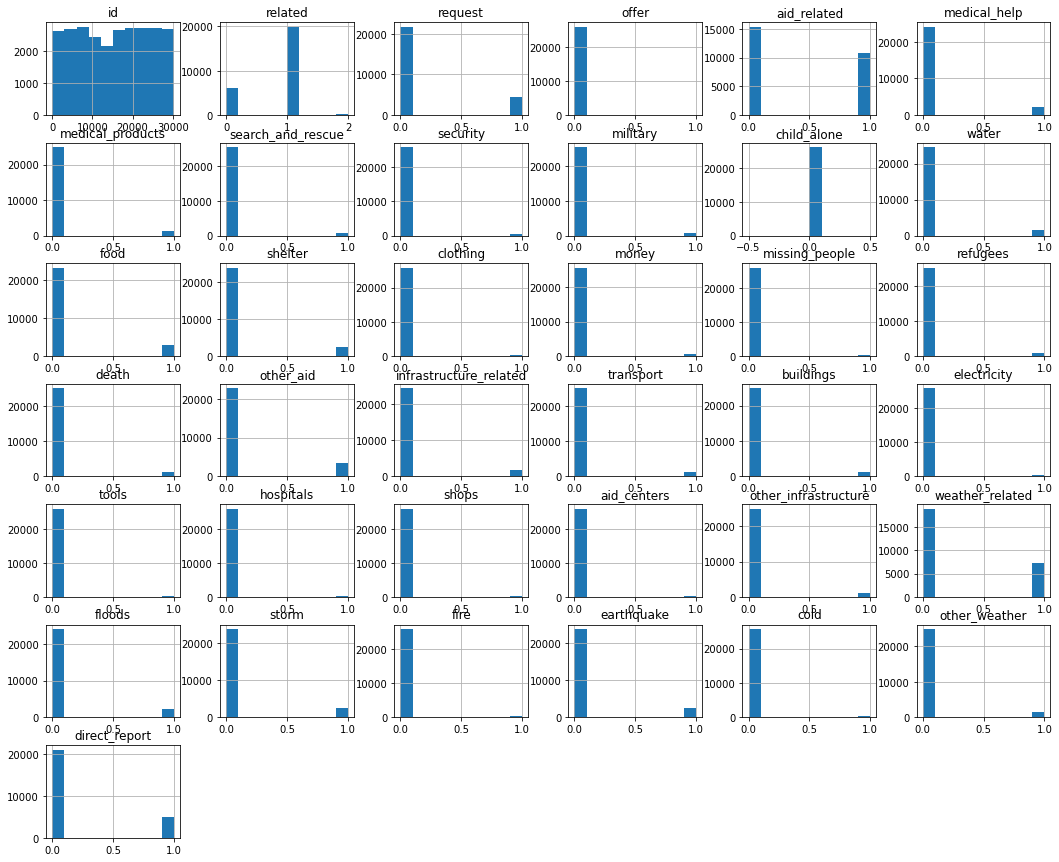

In [7]:
df.hist(figsize=(18,15));

In [8]:
# value 2 in the related column is invalid
# I will replace the value 2 to 1, which is the majority class in the filed
df['related'] = df['related'].map(lambda x: 1 if x == 2 else x)

In [9]:
# child_alone column has only zero values
# I will drop the column
df.drop('child_alone', axis=1, inplace=True)

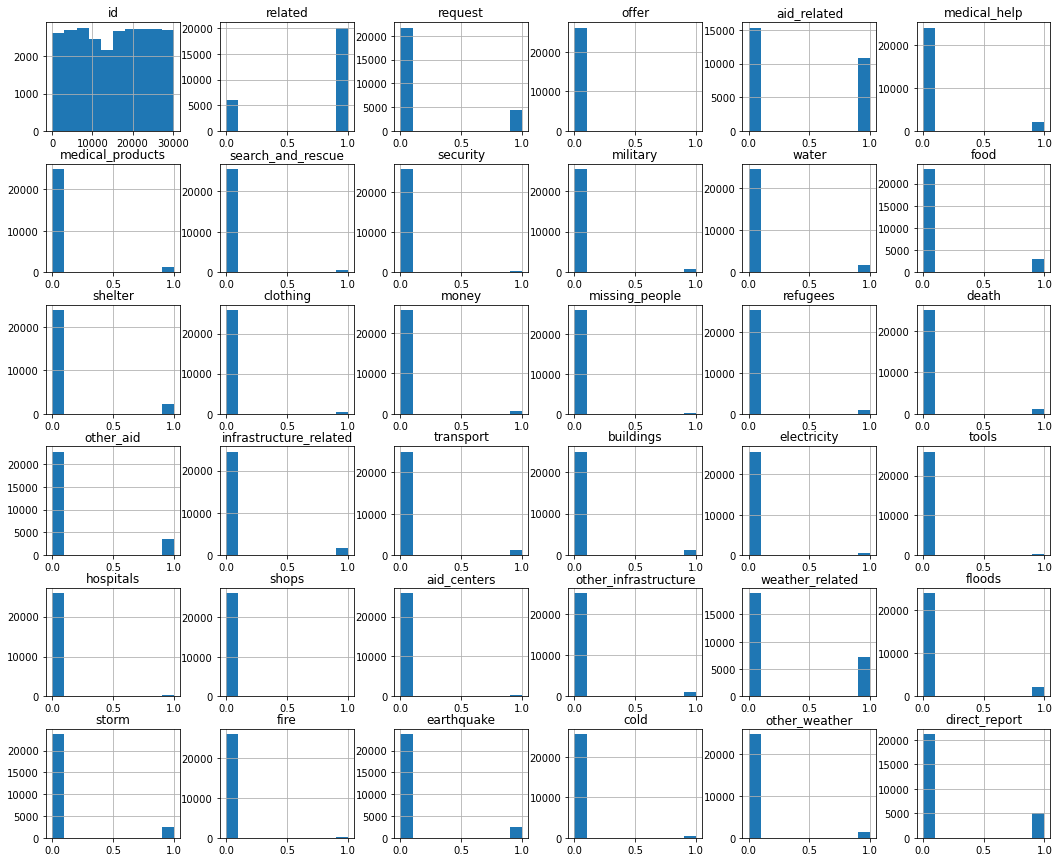

In [10]:
df.hist(figsize=(18,15));

In [11]:
# extract X and y variables for modelling
X = df['message']
y = df.iloc[:,4:]

### 2. Write a tokenization function to process your text data

In [12]:
text = X[10]
print(text)

There's nothing to eat and water, we starving and thirsty.


In [13]:
text = text.lower()
text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
words = word_tokenize(text)
words = [w for w in words if w not in stopwords.words('english')]
lemmed_words = [WordNetLemmatizer().lemmatize(w) for w in words]  
tokens = lemmed_words

In [14]:
print(tokens)

['nothing', 'eat', 'water', 'starving', 'thirsty']


In [15]:
def tokenize(text):
    '''
    INPUT: 
      text: text that needs to be tokenized     
    OUTPUT:       
      clean_tokens: list of tokens that have been normaliazed, 
      removed special characters and stop words, and emmatized
    ''' 
    # capitalization Removal
    text = text.lower()
    # punctation Removal
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    
    # split text into tokens (words)
    words = word_tokenize(text)
    
    # stop words removal
    tokens = [w for w in words if w not in stopwords.words('english')]
    
    ## reduce words to their root form
    lemmatizer = WordNetLemmatizer()
    
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [16]:
for message in X[:12]:
    tokens = tokenize(message)
    print(message)
    print(tokens, '\n')

Weather update - a cold front from Cuba that could pass over Haiti
['weather', 'update', 'cold', 'front', 'cuba', 'could', 'pas', 'haiti'] 

Is the Hurricane over or is it not over
['hurricane'] 

Looking for someone but no name
['looking', 'someone', 'name'] 

UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.
['un', 'report', 'leogane', '80', '90', 'destroyed', 'hospital', 'st', 'croix', 'functioning', 'need', 'supply', 'desperately'] 

says: west side of Haiti, rest of the country today and tonight
['say', 'west', 'side', 'haiti', 'rest', 'country', 'today', 'tonight'] 

Information about the National Palace-
['information', 'national', 'palace'] 

Storm at sacred heart of jesus
['storm', 'sacred', 'heart', 'jesus'] 

Please, we need tents and water. We are in Silo, Thank you!
['please', 'need', 'tent', 'water', 'silo', 'thank'] 

I would like to receive the messages, thank you
['would', 'like', 'receive', 'message', 'thank'] 

I am 

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [17]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier()))
    ])

In [18]:
def build_model():
    
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier()))
    ])
    
    parameters = {
        'vect__ngram_range': ((1, 1), (1, 2)),
        'clf__estimator__min_samples_split': [2, 4],
        'clf__estimator__n_estimators': [100, 150]   
    }
    
    cv = GridSearchCV(pipeline, param_grid=parameters, verbose=2, cv=5)
    
    return cv

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7f928e928f70>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [20]:
predicted = pipeline.predict(X_test)

In [21]:
predicted

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [22]:
print(classification_report(y_test.values, predicted, target_names=y.columns.values, zero_division=0))

                        precision    recall  f1-score   support

               related       0.84      0.95      0.89      5066
               request       0.88      0.50      0.63      1141
                 offer       0.00      0.00      0.00        33
           aid_related       0.77      0.70      0.73      2790
          medical_help       0.59      0.06      0.11       519
      medical_products       0.81      0.10      0.17       355
     search_and_rescue       0.64      0.04      0.08       205
              security       0.00      0.00      0.00       113
              military       0.67      0.04      0.08       234
                 water       0.91      0.34      0.50       427
                  food       0.81      0.60      0.69       775
               shelter       0.83      0.35      0.49       603
              clothing       0.85      0.16      0.27       106
                 money       0.71      0.03      0.06       154
        missing_people       0.00      

### 6. Improve your model
Use grid search to find better parameters. 

In [23]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x7f928e928f70>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=RandomForestClassifier()))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x7f928e928f70>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=RandomForestClassifier()),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf_

In [24]:
# parameters = {
#     'vect__ngram_range': ((1, 1), (1, 2)),
#     'clf__estimator__min_samples_split': [2, 4],
#     'clf__estimator__n_estimators': [100, 150]   
# }
   
# cv = GridSearchCV(pipeline, param_grid=parameters, verbose=2, cv=5)

In [27]:
parameters = {
    'vect__ngram_range': ((1, 1), (1, 2)),
    'clf__estimator__min_samples_split': [2],
    'clf__estimator__n_estimators': [100]   
}
   
cv = GridSearchCV(pipeline, param_grid=parameters, verbose=2, cv=5)

In [28]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, vect__ngram_range=(1, 1); total time= 5.0min
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, vect__ngram_range=(1, 1); total time= 4.9min
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, vect__ngram_range=(1, 1); total time= 5.0min
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, vect__ngram_range=(1, 1); total time= 5.2min
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, vect__ngram_range=(1, 1); total time= 5.2min
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, vect__ngram_range=(1, 2); total time=11.4min
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, vect__ngram_range=(1, 2); total time=10.0min
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_e

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x7f928e928f70>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier()))]),
             param_grid={'clf__estimator__min_samples_split': [2],
                         'clf__estimator__n_estimators': [100],
                         'vect__ngram_range': ((1, 1), (1, 2))},
             verbose=2)

In [29]:
cv.cv_results_

{'mean_fit_time': array([280.94357028, 566.38786678]),
 'std_fit_time': array([ 5.33841604, 53.93231902]),
 'mean_score_time': array([22.20638819, 24.41218104]),
 'std_score_time': array([0.22959584, 2.28260867]),
 'param_clf__estimator__min_samples_split': masked_array(data=[2, 2],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_clf__estimator__n_estimators': masked_array(data=[100, 100],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_vect__ngram_range': masked_array(data=[(1, 1), (1, 2)],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__estimator__min_samples_split': 2,
   'clf__estimator__n_estimators': 100,
   'vect__ngram_range': (1, 1)},
  {'clf__estimator__min_samples_split': 2,
   'clf__estimator__n_estimators': 100,
   'vect__ngram_range': (1, 2)}],
 'split0_test_score': array([0.27205695, 0.27637935]),
 'split1_test_score': ar

In [30]:
print(cv.best_params_)

{'clf__estimator__min_samples_split': 2, 'clf__estimator__n_estimators': 100, 'vect__ngram_range': (1, 1)}


In [32]:
optimised_model = cv.best_estimator_
print(optimised_model)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7f928e928f70>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [33]:
opt_predicted = optimised_model.predict(X_test)

In [35]:
print(classification_report(y_test.values, opt_predicted, target_names=y.columns.values, zero_division=0))

                        precision    recall  f1-score   support

               related       0.84      0.95      0.89      5066
               request       0.87      0.49      0.63      1141
                 offer       0.00      0.00      0.00        33
           aid_related       0.77      0.69      0.73      2790
          medical_help       0.67      0.08      0.14       519
      medical_products       0.84      0.11      0.19       355
     search_and_rescue       0.57      0.02      0.04       205
              security       0.00      0.00      0.00       113
              military       0.72      0.08      0.14       234
                 water       0.91      0.34      0.49       427
                  food       0.81      0.57      0.67       775
               shelter       0.83      0.36      0.50       603
              clothing       0.85      0.16      0.27       106
                 money       0.75      0.04      0.07       154
        missing_people       0.00      

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [36]:
with open('nlp_model.pkl', 'wb') as f:
    pickle.dump(optimised_model, f)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.